<a href="https://colab.research.google.com/github/komorra/ACA/blob/main/komorra_ACA_Augmented_Classifier_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT License

Copyright 2022 Mariusz Komorowski (komorra)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



# What is ACA?

*   Generative algorithm, that can generate images, with support of any image classifier
*   It doesn't need image generators
*   It optimizes input image space "directly", optimizing it using augmentation, to match given classifier output
*   It can help researchers to optimize their image classifiers

It is highly recommended to run this Colab notebook with GPU backend

# Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# ACA Model Definition

In [23]:
class ACA:
  def __init__(self, 
               classifier,
               num_channels = 3,
               cls_input_shape = (224,224), 
               input_detail_dim = (224,224),
               input_bkg_dim = (16,16),
               detail_weight = 1.0,
               bkg_weight = 1.0,
               noise_weight = 0.01,
               aug_batch_size = 10,
               custom_aug = None,
               aug_scale = 0.1,
               chkp_epoch = 100,
               lr = 0.02,
               custom_loss_fn = None,
               device = 'cpu'                       
               ):
    self.classifier = classifier
    self.num_channels = num_channels
    self.cls_input_shape = cls_input_shape
    self.input_detail_dim = input_detail_dim
    self.input_bkg_dim = input_bkg_dim
    self.detail_weight = detail_weight
    self.bkg_weight = bkg_weight
    self.noise_weight = noise_weight
    self.aug_batch_size = aug_batch_size
    aug_fn = torch.nn.Sequential(
        transforms.RandomAffine(15, (aug_scale,aug_scale), (1.0-aug_scale,1.0+aug_scale), 0.1 * aug_scale, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2*aug_scale,0.2*aug_scale,0.2*aug_scale,0.5*aug_scale)
    )
    self.custom_aug = custom_aug if custom_aug != None else aug_fn
    self.aug_scale = aug_scale
    self.chkp_epoch = chkp_epoch
    self.lr = lr
    self.custom_loss_fn = custom_loss_fn if custom_loss_fn != None else self.loss_fn
    self.device = device        
    self.color_restrict = torch.sigmoid
    self.ups = torch.nn.Upsample(self.cls_input_shape, mode='bilinear')
    self.tp = transforms.Compose([
        transforms.ToPILImage()
    ])


  def loss_fn(self, x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).pow(2.0).mul(2)

  def compose(self, bkg, detail, noise = None):
    noise = noise if noise != None else torch.zeros(self.num_channels, self.cls_input_shape[0], self.cls_input_shape[1]).to(self.device)
    u_bkg = self.ups(torch.stack([bkg])).reshape(noise.shape)
    u_detail = self.ups(torch.stack([detail])).reshape(noise.shape)
    composed = u_bkg * self.bkg_weight + u_detail * self.detail_weight + noise
    composed = self.color_restrict(composed)
    return composed

  def __call__(self, cls_output, epochs = 2000):
    detail = torch.nn.Parameter(torch.zeros(self.num_channels, self.input_detail_dim[0], self.input_detail_dim[1]).to(self.device), requires_grad=True)
    bkg = torch.nn.Parameter(torch.zeros(self.num_channels, self.input_bkg_dim[0], self.input_bkg_dim[1]).to(self.device), requires_grad=True)

    par = [detail, bkg]
    optim = torch.optim.Adam(par, lr=self.lr)

    cls_output = cls_output.repeat(self.aug_batch_size, 1).to(self.device)    

    for ep in range(epochs):
      batch = []
      
      for i in range(self.aug_batch_size):
        noise = (torch.rand(self.num_channels,self.cls_input_shape[0],self.cls_input_shape[1]).to(self.device)*2.0-1.0)*self.noise_weight
        comp = self.compose(bkg, detail, noise)
        aug = self.custom_aug(comp)
        batch.append(aug)
      
      batch = torch.stack(batch)

      optim.zero_grad()
      cls_comp = self.classifier(batch)
      
      loss = self.custom_loss_fn(cls_comp, cls_output).mean()
      loss.backward()
      optim.step()

      if self.chkp_epoch > 0 and ep % self.chkp_epoch == 0:
        print(f'Ep:{ep}/{epochs}, Loss:{loss.detach().item()}')
        cmp = self.compose(bkg.detach(), detail.detach())
        display(self.tp(cmp))

    cmp = self.compose(bkg.detach(), detail.detach())
    return cmp    

# OpenAI CLIP Example

Using ACA with CLIP classifier

In [3]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hnnzsk4p
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-hnnzsk4p
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=56a9074705aa852759f01522b04ec07aab95d933fe3ab2072ad6e01e87eefb54
  Stored in directory: /tmp/pip-ephem-wheel-cache-zxrsx4mp/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [4]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torch
import clip

model, _ = clip.load("ViT-B/32", device=device)
model.eval().requires_grad_(False).to(device)

In [33]:
prompt = "Dance party"
text = clip.tokenize(prompt).to(device)
text_embed = model.encode_text(text).detach()
tp = transforms.Compose([
    transforms.ToPILImage()
])

Ep:0/2000, Loss:0.7880859375


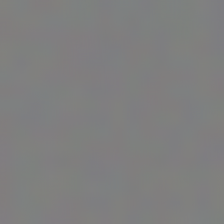

Ep:100/2000, Loss:0.68359375


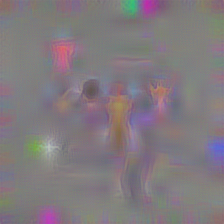

Ep:200/2000, Loss:0.64794921875


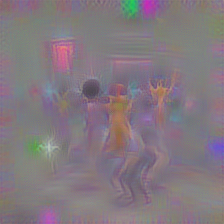

Ep:300/2000, Loss:0.63671875


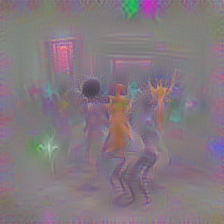

Ep:400/2000, Loss:0.63037109375


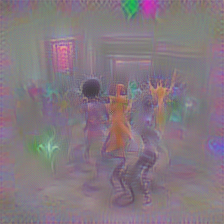

Ep:500/2000, Loss:0.62890625


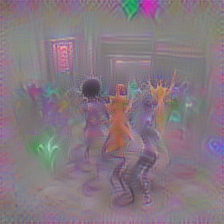

Ep:600/2000, Loss:0.625


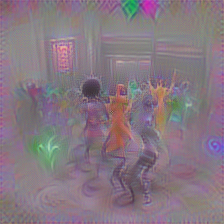

Ep:700/2000, Loss:0.62451171875


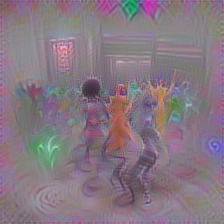

Ep:800/2000, Loss:0.61083984375


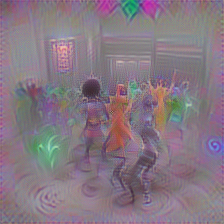

Ep:900/2000, Loss:0.6083984375


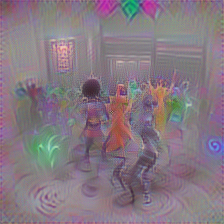

Ep:1000/2000, Loss:0.61376953125


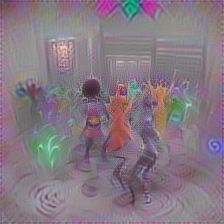

Ep:1100/2000, Loss:0.6181640625


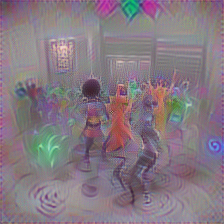

Ep:1200/2000, Loss:0.60498046875


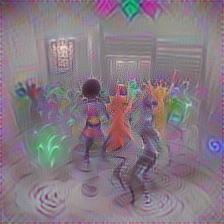

Ep:1300/2000, Loss:0.5966796875


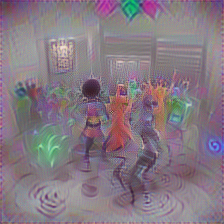

Ep:1400/2000, Loss:0.595703125


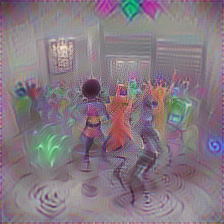

Ep:1500/2000, Loss:0.59765625


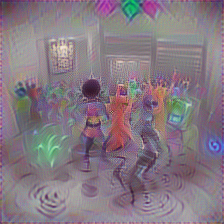

Ep:1600/2000, Loss:0.5908203125


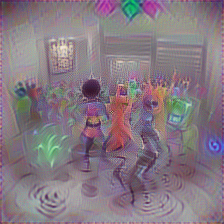

Ep:1700/2000, Loss:0.59619140625


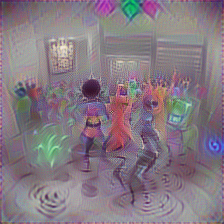

Ep:1800/2000, Loss:0.58740234375


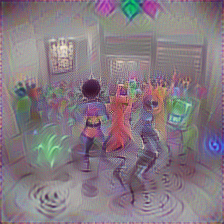

Ep:1900/2000, Loss:0.60205078125


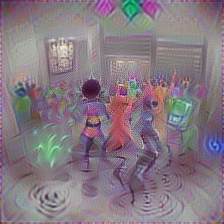

Result


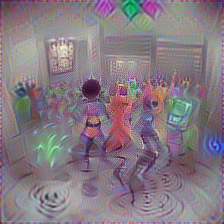

In [34]:
aca = ACA(model.encode_image, device=device, aug_scale=0.3, detail_weight=0.2, noise_weight=0.05)
generated = aca(text_embed)
print("Result")
display(tp(generated))